# Testing PID controller

This notebook shows how to test and tune PID controller. 


* The PID controller has to be implemented in [pid.py](./pid.py) first;
* Make sure ipywidgets is enabled with command: 
    ```sh
    jupyter nbextension enable --py widgetsnbextension
    ```
    read more in [ipywidgets wiki](https://github.com/jupyter-widgets/ipywidgets/blob/master/README.md#install)

In [1]:
%matplotlib notebook
from matplotlib import pylab as plt
from ipywidgets import interact, interact_manual
from IPython import display
from collections import deque

## start simspark
Start SimSpark simulator as described in [last lecture](../introduction/README.md)

## run PIDAgent
Run all code below, there is plot show current joint angle and desired joint angle.

You can set target value and tune the PID parameters to get better results. 


In [2]:
from pid import PIDAgent
agent = PIDAgent()

aW50ZXJhY3RpdmUoY2hpbGRyZW49KEludFNsaWRlcih2YWx1ZT01MCwgZGVzY3JpcHRpb249dSdrcCcpLCBGbG9hdFNsaWRlcih2YWx1ZT0wLjAsIGRlc2NyaXB0aW9uPXUna2knLCBtYXg9Mi7igKY=


<IPython.core.display.Javascript object>


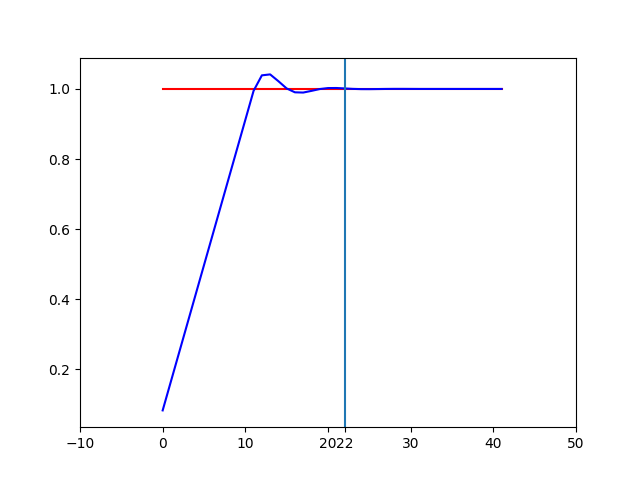

In [3]:
def set_pid_parameters(kp, ki, kd, delay=0):
    global agent
    agent.joint_controller.Kp = kp
    agent.joint_controller.Ki = ki
    agent.joint_controller.Kd = kd
    agent.joint_controller.set_delay(delay)

joint_name = 'HeadYaw'
sensor = deque(maxlen=1000)
target = deque(maxlen=1000)

def set_joint_name(name):
    global joint_name
    if joint_name != name:
        joint_name = name
        sensor.clear()
        target.clear()

def set_joint_target(value):
    agent.target_joints[joint_name] = value

manual_pause = False

def set_pause(pause):
    global manual_pause
    manual_pause = pause
    
@interact_manual(kp=(0, 100, 1), ki=(-2, 2, 0.05), kd=(-2, 2, 0.05), delay=(0, 5), name=agent.joint_names, value=(-2.5, 2.5, 0.1), pause=False)
def set_all(kp, ki, kd, delay, name, value, pause):
    set_pid_parameters(kp, ki, kd, delay)
    set_joint_name(name)
    set_joint_target(value)
    set_pause(pause)

In [4]:
from itertools import islice, ifilter

HISTORY_TO_CHECK = 20
MAX_DIFFERENCE = 1e-3
def no_diff(history, current):
    return len(history) > 0 and max((
        abs(current - x) for x in
        islice(reversed(history), HISTORY_TO_CHECK)
    )) < MAX_DIFFERENCE

def add_time_vline():
    i = None
    had_one = False
    for j, vals in enumerate(zip(sensor, target)):
        if abs(vals[0] - vals[1]) < MAX_DIFFERENCE:
            had_one = True
        else:
            i = j

    if i is not None:
        plt.axvline(i)
        plt.xticks(list(plt.xticks()[0]) + [i])

# inject plotting input agent's loop
cycle = 0
paused = False
orig_sense_think_act = agent.sense_think_act
def sense_think_act():
    global cycle, paused, manual_pauses
    if manual_pause:
        return
    cycle += 1
    orig_sense_think_act()
    if no_diff(sensor, agent.perception.joint[joint_name]) and \
            no_diff(target, agent.target_joints[joint_name]):
        paused = True
        return
    elif paused:
        sensor.clear()
        target.clear()
        paused = False

    sensor.append(agent.perception.joint[joint_name])
    target.append(agent.target_joints[joint_name])

    if cycle % 10 == 0:  # plot every 10 cycles
        plt.cla()
        plt.plot(target, '-r')
        plt.plot(sensor, '-b')
        add_time_vline()
        plt.show()
        #display.clear_output(wait=True)
        #display.display(gcf())
agent.sense_think_act = sense_think_act
agent.start()